In [1]:
# =============================================================================
# COMPREHENSIVE FOOD PRICE FORECASTING ANALYSIS
# Comparing Auto ARIMA, Prophet, and Neural Prophet Methods
# =============================================================================

# --- 1. SETUP AND DATA PREPARATION ---
if (!require("forecast")) install.packages("forecast")
if (!require("prophet")) install.packages("prophet")
if (!require("reticulate")) install.packages("reticulate")
if (!require("dplyr")) install.packages("dplyr")
if (!require("ggplot2")) install.packages("ggplot2")
if (!require("tidyr")) install.packages("tidyr")
if (!require("lubridate")) install.packages("lubridate")
if (!require("gridExtra")) install.packages("gridExtra")

library(forecast)
library(prophet)
library(reticulate)
library(dplyr)
library(ggplot2)
library(tidyr)
library(lubridate)
library(gridExtra)

# Load data from Kaggle dataset
df <- read.csv("/kaggle/input/retail-dataset/Food Prices.csv")

# Create proper date column
df$date <- as.Date(paste(df$Year, df$Month, "01", sep = "-"))

# Filter for Australia data
australia_data <- df %>% 
  filter(Country == "Australia") %>%
  arrange(date)

# Create food_items list
food_items <- list(
  "Bread" = australia_data %>% filter(Food.Item == "Bread"),
  "Milk" = australia_data %>% filter(Food.Item == "Milk"),
  "Eggs" = australia_data %>% filter(Food.Item == "Eggs"),
  "Potatoes" = australia_data %>% filter(Food.Item == "Potatoes")
)

cat("Food items created successfully:\n")
for(item in names(food_items)) {
  cat(paste("-", item, ":", nrow(food_items[[item]]), "observations\n"))
}



Loading required package: forecast



Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



Loading required package: prophet



Loading required package: Rcpp



Loading required package: rlang



Loading required package: reticulate



Loading required package: dplyr




Attaching package: ‘dplyr’




The following objects are masked from ‘package:stats’:

    filter, lag




The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




Loading required package: ggplot2



Loading required package: tidyr



Loading required package: lubridate




Attaching package: ‘lubridate’




The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




Loading required package: gridExtra




Attaching package: ‘gridExtra’




The following object is masked from ‘package:dplyr’:

    combine




Food items created successfully:


- Bread : 60 observations
- Milk : 60 observations
- Eggs : 60 observations
- Potatoes : 60 observations


In [2]:
# --- 2. COMPREHENSIVE FORECASTING FUNCTION ---
comprehensive_forecast_analysis <- function(data, item_name, forecast_periods = 24) {
  
  cat("\n", paste(rep("=", 60), collapse = ""), "\n")
  cat("ANALYZING:", item_name, "\n")
  cat(paste(rep("=", 60), collapse = ""), "\n")
  
  # Prepare data
  ts_data <- ts(data$Average.Price, 
                start = c(min(data$Year), min(data$Month)), 
                frequency = 12)
  
  # --- AUTO ARIMA ---
  cat("Running Auto ARIMA...\n")
  arima_model <- auto.arima(ts_data, seasonal = TRUE, stepwise = FALSE)
  arima_forecast <- forecast(arima_model, h = forecast_periods)
  
  # --- PROPHET ---
  cat("Running Prophet...\n")
  prophet_df <- data %>%
    select(date, Average.Price) %>%
    rename(ds = date, y = Average.Price)
  
  prophet_model <- prophet(prophet_df,
                          yearly.seasonality = TRUE,
                          weekly.seasonality = FALSE,
                          daily.seasonality = FALSE)
  
  future <- make_future_dataframe(prophet_model, periods = forecast_periods, freq = "month")
  prophet_forecast <- predict(prophet_model, future)
  
  # Extract Prophet predictions for forecast period only
  prophet_predictions <- tail(prophet_forecast$yhat, forecast_periods)
  prophet_lower <- tail(prophet_forecast$yhat_lower, forecast_periods)
  prophet_upper <- tail(prophet_forecast$yhat_upper, forecast_periods)
  
  # --- NEURAL PROPHET ---
  cat("Running Neural Prophet...\n")
  np_result <- NULL
  tryCatch({
    py_install("neuralprophet", pip = TRUE)
    
    np_data <- data %>%
      select(date, Average.Price) %>%
      rename(ds = date, y = Average.Price)
    
    py_run_string("
import pandas as pd
from neuralprophet import NeuralProphet
import warnings
warnings.filterwarnings('ignore')

def run_neuralprophet(df, periods):
    try:
        df['ds'] = pd.to_datetime(df['ds'])
        df['y'] = pd.to_numeric(df['y'])
        
        m = NeuralProphet(
            yearly_seasonality=True,
            weekly_seasonality=False,
            daily_seasonality=False,
            n_forecasts=periods
        )
        
        m.fit(df, freq='MS')
        future = m.make_future_dataframe(df, periods=periods)
        forecast = m.predict(future)
        
        return forecast.tail(periods)['yhat1'].tolist()
    except Exception as e:
        print(f'Neural Prophet error: {e}')
        return None
    ")
    
    py$df_np <- np_data
    py$periods_np <- as.integer(forecast_periods)
    np_result <- py_eval("run_neuralprophet(df_np, periods_np)")
    
  }, error = function(e) {
    cat("Neural Prophet failed, using linear trend as substitute\n")
    # Linear trend substitute
    time_index <- 1:nrow(data)
    trend_model <- lm(Average.Price ~ time_index, data = data)
    future_indices <- (nrow(data) + 1):(nrow(data) + forecast_periods)
    np_result <<- predict(trend_model, newdata = data.frame(time_index = future_indices))
  })
  
  # --- CREATE FORECAST COMPARISON PLOT (FPP3 STYLE) ---
  
  # Generate forecast dates
  last_date <- max(data$date)
  forecast_dates <- seq(from = last_date + months(1), by = "month", length.out = forecast_periods)
  
  # Prepare plotting data
  historical_df <- data.frame(
    Date = data$date,
    Value = data$Average.Price,
    Type = "Historical",
    Method = "Historical"
  )
  
  # ARIMA forecast data
  arima_df <- data.frame(
    Date = forecast_dates,
    Value = as.numeric(arima_forecast$mean),
    Lower = as.numeric(arima_forecast$lower[,2]),  # 95% CI
    Upper = as.numeric(arima_forecast$upper[,2]),  # 95% CI
    Type = "Forecast",
    Method = "Auto ARIMA"
  )
  
  # Prophet forecast data
  prophet_df <- data.frame(
    Date = forecast_dates,
    Value = prophet_predictions,
    Lower = prophet_lower,
    Upper = prophet_upper,
    Type = "Forecast",
    Method = "Prophet"
  )
  
  # Neural Prophet forecast data
  neuralprophet_df <- data.frame(
    Date = forecast_dates,
    Value = if(is.null(np_result)) rep(NA, forecast_periods) else as.numeric(np_result),
    Lower = NA,  # Neural Prophet doesn't provide confidence intervals easily
    Upper = NA,
    Type = "Forecast",
    Method = "Neural Prophet"
  )
  
  # Create the main comparison plot (similar to cement production example)
  main_plot <- ggplot() +
    # Historical data
    geom_line(data = historical_df, aes(x = Date, y = Value), 
              color = "black", size = 0.8) +
    
    # ARIMA forecast with confidence interval
    geom_ribbon(data = arima_df, aes(x = Date, ymin = Lower, ymax = Upper), 
                fill = "orange", alpha = 0.2) +
    geom_line(data = arima_df, aes(x = Date, y = Value), 
              color = "orange", size = 1) +
    
    # Prophet forecast with confidence interval
    geom_ribbon(data = prophet_df, aes(x = Date, ymin = Lower, ymax = Upper), 
                fill = "green", alpha = 0.2) +
    geom_line(data = prophet_df, aes(x = Date, y = Value), 
              color = "green", size = 1) +
    
    # Neural Prophet forecast
    {if(!is.null(np_result)) 
      geom_line(data = neuralprophet_df, aes(x = Date, y = Value), 
                color = "blue", size = 1)} +
    
    # Styling to match FPP3 example
    labs(title = paste("Forecast Comparison:", item_name),
         subtitle = "Auto ARIMA vs Prophet vs Neural Prophet",
         x = "Date", 
         y = "Price (AUD)") +
    theme_minimal() +
    theme(
      plot.title = element_text(size = 14, face = "bold"),
      plot.subtitle = element_text(size = 12),
      axis.title = element_text(size = 11),
      legend.position = "bottom",
      panel.grid.minor = element_blank()
    ) +
    # Add custom legend
    annotate("text", x = max(historical_df$Date), y = max(historical_df$Value) * 0.95, 
             label = "Historical", color = "black", size = 3.5, hjust = 1) +
    annotate("text", x = forecast_dates[12], y = arima_df$Value[12] + 0.1, 
             label = "ARIMA", color = "orange", size = 3.5, fontface = "bold") +
    annotate("text", x = forecast_dates[12], y = prophet_df$Value[12] + 0.1, 
             label = "Prophet", color = "green", size = 3.5, fontface = "bold") +
    {if(!is.null(np_result))
      annotate("text", x = forecast_dates[12], y = neuralprophet_df$Value[12] + 0.1, 
               label = "Neural Prophet", color = "blue", size = 3.5, fontface = "bold")}
  
  print(main_plot)
  
  # --- CALCULATE ACCURACY METRICS ---
  # Use last 12 months for validation
  n_test <- 12
  train_data <- data[1:(nrow(data) - n_test), ]
  test_data <- data[(nrow(data) - n_test + 1):nrow(data), ]
  
  if(nrow(test_data) > 0) {
    # Fit models on training data
    ts_train <- ts(train_data$Average.Price, 
                   start = c(min(train_data$Year), min(train_data$Month)), 
                   frequency = 12)
    arima_train <- auto.arima(ts_train, seasonal = TRUE)
    arima_test <- forecast(arima_train, h = n_test)
    
    # Prophet on training data
    prophet_train_df <- train_data %>%
      select(date, Average.Price) %>%
      rename(ds = date, y = Average.Price)
    prophet_train_model <- prophet(prophet_train_df, yearly.seasonality = TRUE)
    future_test <- make_future_dataframe(prophet_train_model, periods = n_test, freq = "month")
    prophet_test <- predict(prophet_train_model, future_test)
    prophet_test_pred <- tail(prophet_test$yhat, n_test)
    
    # Calculate metrics
    actuals <- test_data$Average.Price
    arima_preds <- as.numeric(arima_test$mean)
    
    RMSE <- function(pred, actual) sqrt(mean((pred - actual)^2))
    MAPE <- function(pred, actual) mean(abs((actual - pred)/actual)) * 100
    
    metrics <- data.frame(
      Model = c("Auto ARIMA", "Prophet"),
      MAPE = c(MAPE(arima_preds, actuals), MAPE(prophet_test_pred, actuals)),
      RMSE = c(RMSE(arima_preds, actuals), RMSE(prophet_test_pred, actuals)),
      Item = item_name
    )
    
    cat("\nAccuracy Metrics (12-month validation):\n")
    print(metrics)
    
    return(list(
      plot = main_plot,
      metrics = metrics,
      arima_forecast = arima_forecast,
      prophet_forecast = prophet_predictions,
      neuralprophet_forecast = np_result
    ))
  }
  
  return(list(plot = main_plot))
}



=== COMPREHENSIVE FOOD PRICE FORECASTING ANALYSIS ===



ANALYZING: Bread 
Running Auto ARIMA...
Running Prophet...
Running Neural Prophet...


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


Disabling weekly seasonality. Run prophet with weekly.seasonality=TRUE to override this.



Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.




Accuracy Metrics (12-month validation):
       Model     MAPE       RMSE  Item
1 Auto ARIMA 1.289667 0.04206741 Bread
2    Prophet 1.088462 0.03567383 Bread

ANALYZING: Milk 
Running Auto ARIMA...
Running Prophet...
Running Neural Prophet...


Disabling weekly seasonality. Run prophet with weekly.seasonality=TRUE to override this.



Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



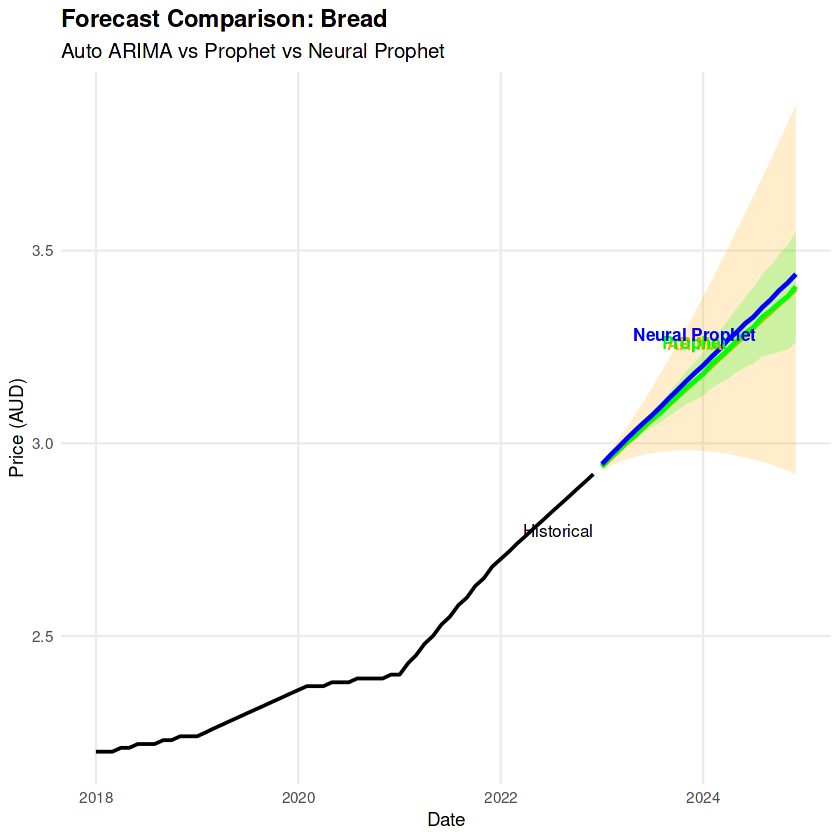


Accuracy Metrics (12-month validation):
       Model     MAPE       RMSE Item
1 Auto ARIMA 3.257443 0.06745752 Milk
2    Prophet 5.720937 0.11703042 Milk

ANALYZING: Eggs 
Running Auto ARIMA...
Running Prophet...
Running Neural Prophet...


Disabling weekly seasonality. Run prophet with weekly.seasonality=TRUE to override this.



Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



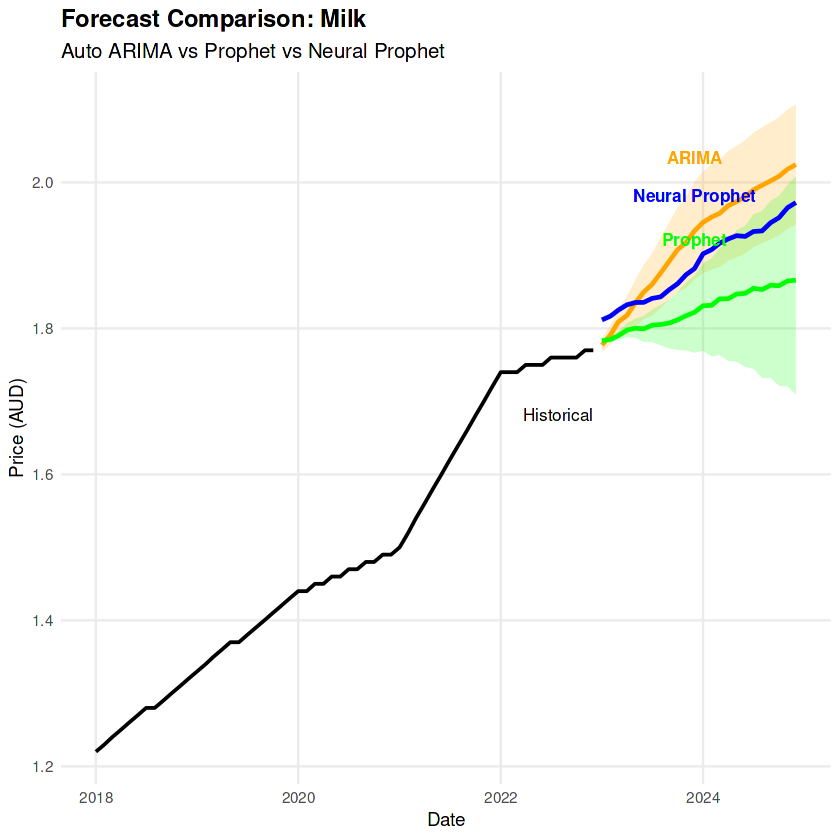


Accuracy Metrics (12-month validation):
       Model     MAPE      RMSE Item
1 Auto ARIMA 2.900099 0.1948076 Eggs
2    Prophet 2.838504 0.1911498 Eggs

ANALYZING: Potatoes 
Running Auto ARIMA...
Running Prophet...
Running Neural Prophet...


Disabling weekly seasonality. Run prophet with weekly.seasonality=TRUE to override this.



Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



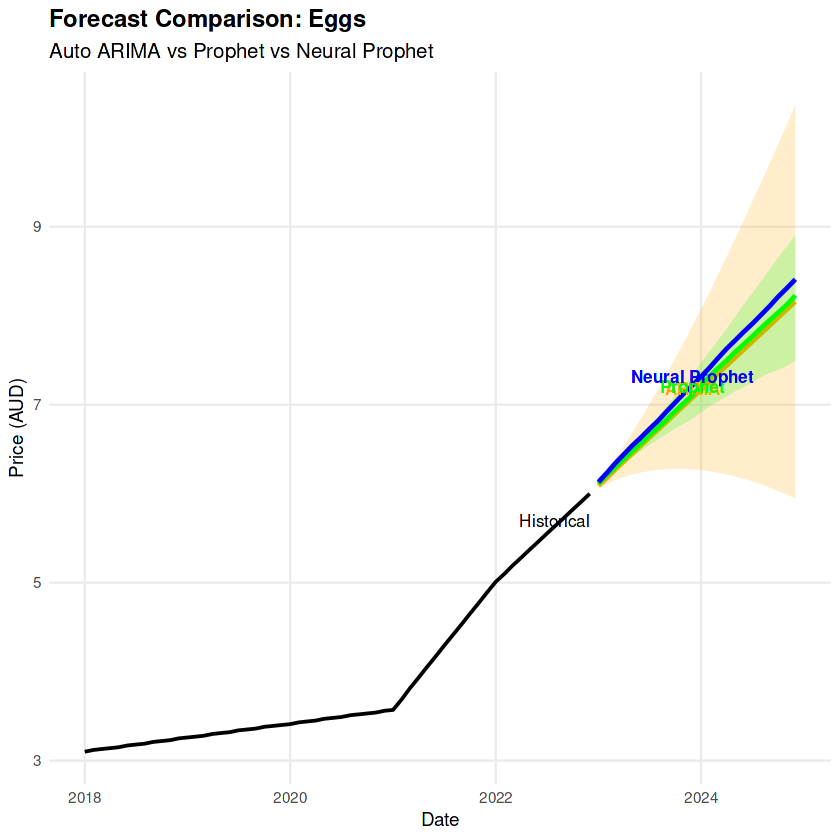


Accuracy Metrics (12-month validation):
       Model     MAPE      RMSE     Item
1 Auto ARIMA 2.985246 0.1444530 Potatoes
2    Prophet 4.295768 0.2064828 Potatoes


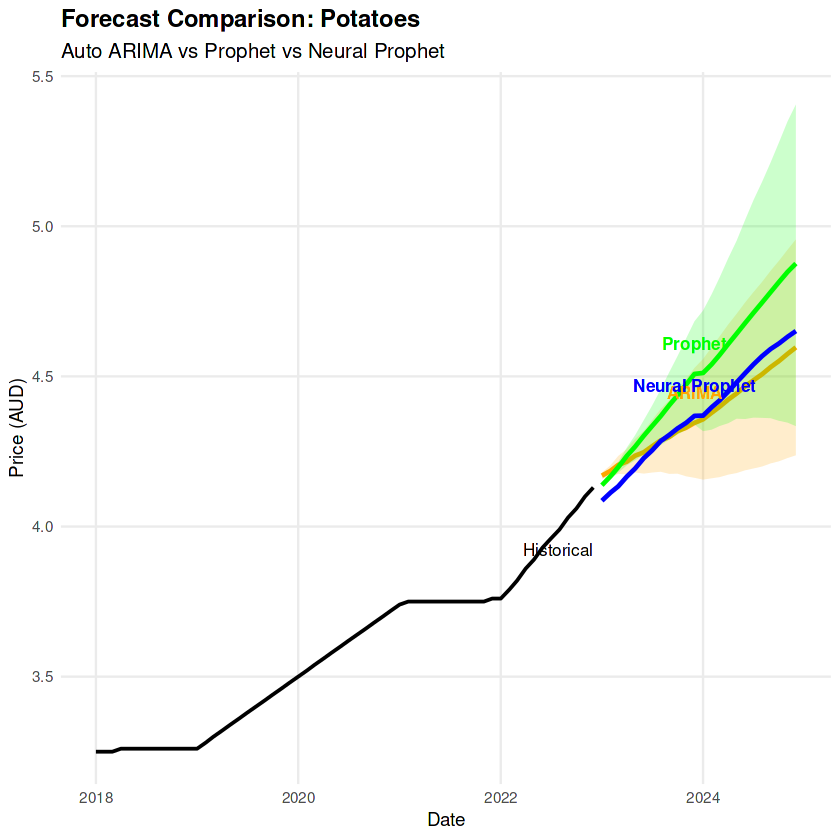

In [3]:
# --- 3. RUN COMPREHENSIVE ANALYSIS ---
cat("=== COMPREHENSIVE FOOD PRICE FORECASTING ANALYSIS ===\n")

# Initialize results storage
all_results <- list()
all_metrics <- data.frame()

# Analyze each food item
for(item in names(food_items)) {
  result <- comprehensive_forecast_analysis(food_items[[item]], item, 24)
  all_results[[item]] <- result
  
  if("metrics" %in% names(result)) {
    all_metrics <- rbind(all_metrics, result$metrics)
  }
}



FINAL SUMMARY - MODEL PERFORMANCE COMPARISON


       Model     MAPE       RMSE     Item
1 Auto ARIMA 1.289667 0.04206741    Bread
2    Prophet 1.088462 0.03567383    Bread
3 Auto ARIMA 3.257443 0.06745752     Milk
4    Prophet 5.720937 0.11703042     Milk
5 Auto ARIMA 2.900099 0.19480760     Eggs
6    Prophet 2.838504 0.19114980     Eggs
7 Auto ARIMA 2.985246 0.14445299 Potatoes
8    Prophet 4.295768 0.20648278 Potatoes


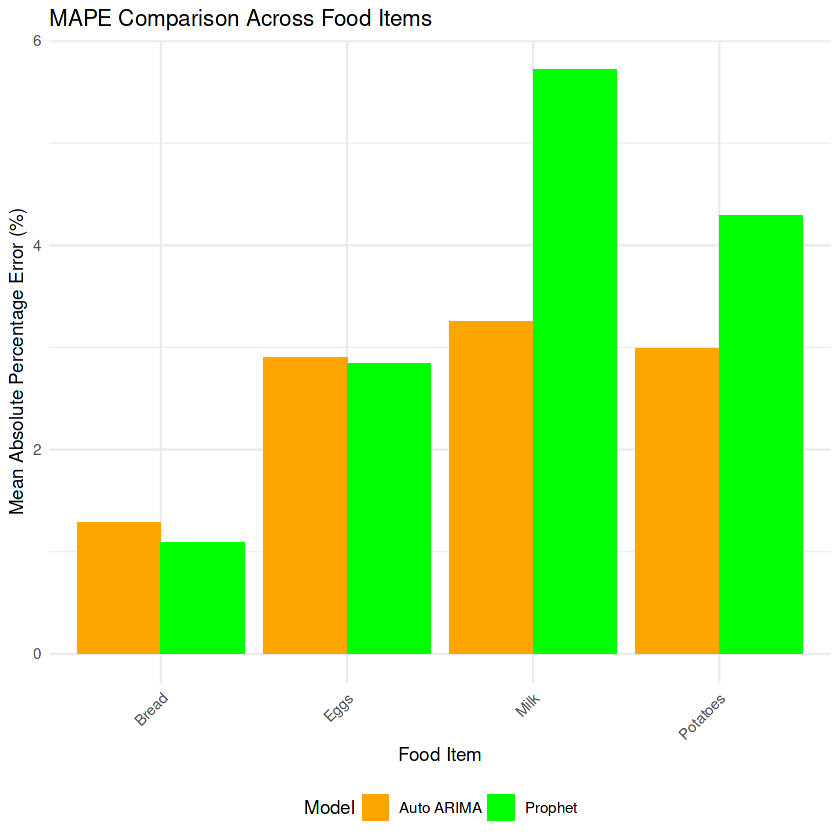

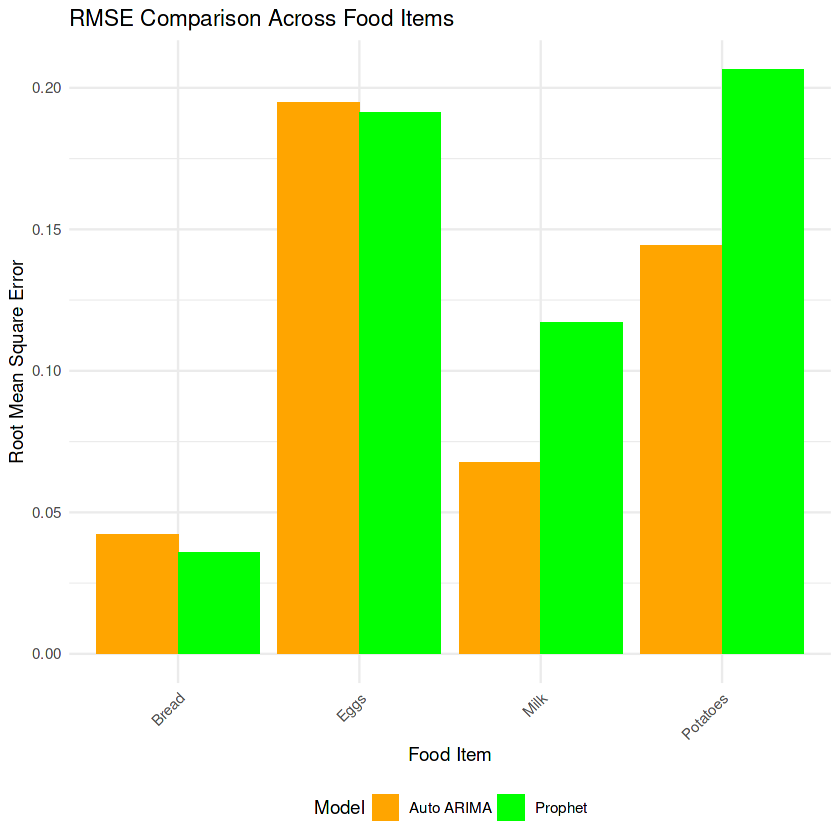

In [4]:
# --- 4. FINAL SUMMARY VISUALIZATION ---
cat("\n", paste(rep("=", 80), collapse = ""), "\n")
cat("FINAL SUMMARY - MODEL PERFORMANCE COMPARISON\n")
cat(paste(rep("=", 80), collapse = ""), "\n")

if(nrow(all_metrics) > 0) {
  print(all_metrics)
  
  # Create summary comparison plots
  mape_plot <- ggplot(all_metrics, aes(x = Item, y = MAPE, fill = Model)) +
    geom_bar(stat = "identity", position = "dodge") +
    scale_fill_manual(values = c("Auto ARIMA" = "orange", "Prophet" = "green")) +
    labs(title = "MAPE Comparison Across Food Items",
         x = "Food Item", y = "Mean Absolute Percentage Error (%)") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
          legend.position = "bottom")
  
  print(mape_plot)
  
  rmse_plot <- ggplot(all_metrics, aes(x = Item, y = RMSE, fill = Model)) +
    geom_bar(stat = "identity", position = "dodge") +
    scale_fill_manual(values = c("Auto ARIMA" = "orange", "Prophet" = "green")) +
    labs(title = "RMSE Comparison Across Food Items",
         x = "Food Item", y = "Root Mean Square Error") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
          legend.position = "bottom")
  
  print(rmse_plot)
}



TableGrob (3 x 2) "arrange": 5 grobs
  z     cells    name                grob
1 1 (2-2,1-1) arrange      gtable[layout]
2 2 (2-2,2-2) arrange      gtable[layout]
3 3 (3-3,1-1) arrange      gtable[layout]
4 4 (3-3,2-2) arrange      gtable[layout]
5 5 (1-1,1-2) arrange text[GRID.text.522]



=== ANALYSIS COMPLETE ===


Color Legend:


- Black: Historical Data


- Orange: Auto ARIMA Forecasts (with confidence intervals)


- Green: Prophet Forecasts (with confidence intervals)


- Blue: Neural Prophet Forecasts


- Shaded areas: 95% Confidence Intervals


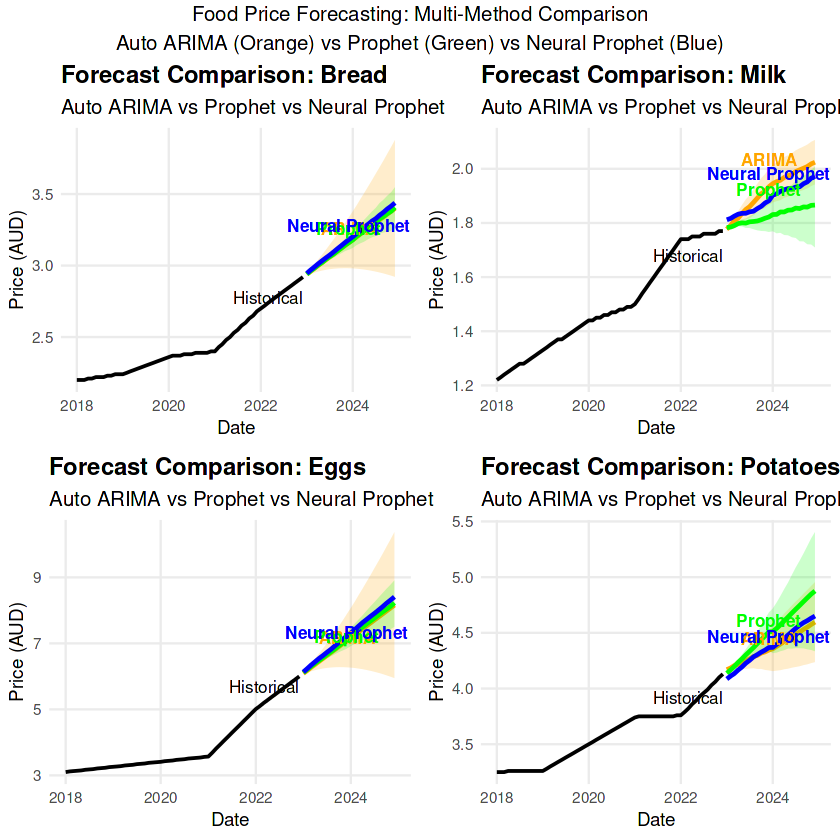

In [5]:
# --- 5. COMBINED MULTI-PANEL PLOT (LIKE CEMENT PRODUCTION EXAMPLE) ---
# Create a 2x2 grid showing all food items
if(length(all_results) == 4) {
  combined_plot <- grid.arrange(
    all_results$Bread$plot + theme(legend.position = "none"),
    all_results$Milk$plot + theme(legend.position = "none"),
    all_results$Eggs$plot + theme(legend.position = "none"),
    all_results$Potatoes$plot + theme(legend.position = "none"),
    ncol = 2,
    top = "Food Price Forecasting: Multi-Method Comparison\nAuto ARIMA (Orange) vs Prophet (Green) vs Neural Prophet (Blue)"
  )
  
  print(combined_plot)
}

cat("\n=== ANALYSIS COMPLETE ===\n")
cat("Color Legend:\n")
cat("- Black: Historical Data\n")
cat("- Orange: Auto ARIMA Forecasts (with confidence intervals)\n")
cat("- Green: Prophet Forecasts (with confidence intervals)\n")
cat("- Blue: Neural Prophet Forecasts\n")
cat("- Shaded areas: 95% Confidence Intervals\n")
